__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
#import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
#from shapely.geometry import Polygon

/opt/venv/python3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_house.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

5830


title                                    adr  \
3756    дом 80 м² на участке 7 сот.  Севастополь,с. Гончарное, ул. Мягкого   
1814   дом 210 м² на участке 4 сот.                   Севастополь, Фиолент   
24    дом 50 м² на участке 2,2 сот.            Севастополь,Монастырское ш.   

       latitude longitude  priceM                      ts  
3756  44.465515  33.70152    4.00 2022-09-16 15:21:10.419  
1814      44.51     33.50    7.90 2022-09-15 11:53:29.976  
24        44.55     33.53    5.30 2022-09-15 11:53:29.976

In [6]:
# gdf[ gdf['title'].str.lower().str.match(r'дом 2'latitude','longitude'23,2.*') ]
df.loc[ df['adr_orig']=='квартал Старый Город', ['latitude','longitude']] = None

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5830 entries, 0 to 5829
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                5830 non-null   object        
 1   price                5830 non-null   int64         
 2   obj_name             5830 non-null   object        
 3   adr_orig             5830 non-null   object        
 4   description          5830 non-null   object        
 5   avito_page           5830 non-null   int64         
 6   ts                   5830 non-null   datetime64[ns]
 7   place                5830 non-null   object        
 8   house_area           5830 non-null   float64       
 9   is_part              5830 non-null   bool          
 10  is_townhouse         5830 non-null   bool          
 11  is_SNT               5830 non-null   bool          
 12  land_area            5830 non-null   float64       
 13  priceM               5830 non-nul

In [8]:
df.sample(3)[cols]

title  \
5145  дом 90,1 м² на участке 12 сот.   
1713    дом 145 м² на участке 5 сот.   
1183    дом 500 м² на участке 8 сот.   

                                                  adr   latitude  longitude  \
5145  Севастополь,садоводческое товарищество Перископ   44.52206  33.505417   
1713          Севастополь,Балаклава, Кизиловая ул., 7  44.507945  33.580615   
1183            Севастополь,с. Ушаково, Урожайная ул.  44.543078  33.544961   

      priceM                      ts  
5145   13.00 2022-09-16 15:21:10.419  
1713   10.99 2022-09-15 11:53:29.976  
1183   66.60 2022-09-15 11:53:29.976

In [9]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

5830
5828


### ограничиваем тип объекта 

In [10]:
print(len(df))
# выкидываем "ущербные" варианты 
# df = df.query('~(is_part|is_SNT|is_townhouse) & (house_area>40.) & (priceM<15.)')
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
print(len(df))

5828
4048


In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

title  \
3501   дом 55 м² на участке 3 сот.   
4148  дом 152 м² на участке 5 сот.   
297   дом 130 м² на участке 4 сот.   

                                                                 adr  \
3501                                Севастополь,Феодосийская ул., 46   
4148       Севастополь,садоводческое товарищество Старый Фиолент, 13   
297   Севастополь,товарищество собственников недвижимости Лазурь, 26   

       latitude  longitude  priceM  
3501      44.59      33.50    5.70  
4148  44.515035  33.476285   12.90  
297     44.5124   33.52421    8.50

In [12]:
del df

In [13]:
cols = ['title','priceM','house_size_category','place','geometry']

# gdf[cols].explore('house_size_category',cmap='rainbow',legend=True,marker_type='marker') 
gdf[cols].explore('house_size_category',cmap='rainbow',legend=True,marker_type='circle_marker') 

In [14]:
cols = ['title','adr','priceM','house_size_category','place','geometry']
gdf[cols].explore('place',cmap='rainbow',legend=True) 

## общая статистика изменение цены

In [15]:
ts = '2022-08-01' # ограничиваем дату

In [16]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['place','house_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count  mean  std  min  10%  25%  \
place       house_size_category dt                                             
bahchisaray 30-50               2022-09-15   34.00  3.48 1.41 1.60 2.00 2.50   
                                2022-09-16   37.00  3.41 1.39 1.60 1.92 2.50   
            50-70               2022-09-15   64.00  4.54 1.89 1.10 2.50 3.18   
                                2022-09-16   64.00  4.54 1.90 1.10 2.50 3.18   
            70-150              2022-09-15   76.00  5.95 2.87 1.40 2.52 4.00   
                                2022-09-16   74.00  5.98 2.86 1.65 2.66 4.00   
            150-300             2022-09-15   50.00  8.51 3.05 1.79 4.60 6.10   
                                2022-09-16   50.00  8.51 3.05 1.79 4.60 6.10   
            300+                2022-09-15    6.00  9.02 3.80 4.80 4.88 5.71   
                                2022-09-16    6.00  9.02 3.80 4.80 4.88 5.71   
sevastopol  30-50               2022-09-15  103.00  5.14 1.81 2.00 3.11 3.80   
                                2022-09-16  101.00  5.16 1.84 2.25 3.15 3.80   
            50-70               2022-09-15  205.00  6.14 2.40 1.68 3.70 4.50   
                                2022-09-16  206.00  6.14 2.34 1.68 3.70 4.50   
            70-150              2022-09-15 1021.00  8.09 2.58 1.50 5.10 6.26   
                                2022-09-16 1003.00  8.08 2.58 1.40 5.00 6.25   
            150-300             2022-09-15  293.00 10.61 2.80 1.80 6.99 8.75   
                                2022-09-16  293.00 10.64 2.79 1.80 7.00 8.80   
            300+                2022-09-15   13.00 10.88 2.42 6.00 8.20 9.90   
                                2022-09-16   13.00 10.88 2.42 6.00 8.20 9.90   
sudak       30-50               2022-09-15    6.00  5.33 3.21 2.80 2.90 3.05   
                                2022-09-16    6.00  5.33 3.21 2.80 2.90 3.05   
                                2022-09-19    6.00  5.33 3.21 2.80 2.90 3.05   
                                2022-09-22    6.00  5.33 3.21 2.80 2.90 3.05   
            50-70               2022-09-15    8.00  5.99 3.16 4.00 4.00 4.15   
                                2022-09-16    9.00  5.73 3.05 3.70 3.94 4.00   
                                2022-09-19   11.00  6.11 3.68 2.65 3.70 4.00   
                                2022-09-22   11.00  6.11 3.68 2.65 3.70 4.00   
            70-150              2022-09-15   41.00  7.25 2.62 1.50 4.20 5.40   
                                2022-09-16   44.00  7.30 2.61 1.50 4.26 5.38   
                                2022-09-19   43.00  7.63 2.60 2.90 4.38 5.45   
                                2022-09-22   42.00  7.66 2.59 2.90 4.34 5.50   
            150-300             2022-09-15   22.00  8.94 3.81 2.00 4.30 5.35   
                                2022-09-16   23.00  8.92 3.72 2.00 4.30 5.40   
                                2022-09-19   20.00  8.80 3.81 2.00 4.26 5.22   
                                2022-09-22   20.00  8.64 3.88 2.00 4.26 5.22   
            300+                2022-09-15    3.00  9.33 0.58 9.00 9.00 9.00   
                                2022-09-16    3.00  9.33 0.58 9.00 9.00 9.00   
                                2022-09-19    3.00  9.33 0.58 9.00 9.00 9.00   
                                2022-09-22    3.00  9.33 0.58 9.00 9.00 9.00   

                                             50%   75%   90%   max  
place       house_size_category dt                                  
bahchisaray 30-50               2022-09-15  3.40  4.00  4.64  7.90  
                                2022-09-16  3.30  4.00  4.58  7.90  
            50-70               2022-09-15  4.05  5.70  6.94 10.50  
                                2022-09-16  4.05  5.70  6.94 10.50  
            70-150              2022-09-15  5.50  7.50 10.15 14.25  
                                2022-09-16  5.50  7.42 10.21 14.25  
            150-300             2022-09-15  7.85 11.38 12.50 14.99  
                                2022-09-16  7.85 11.38 12.50 14

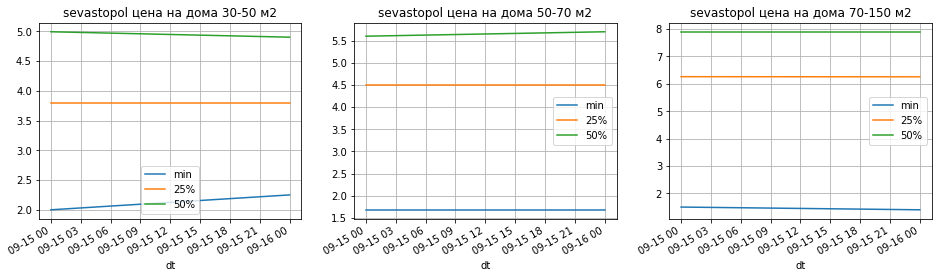

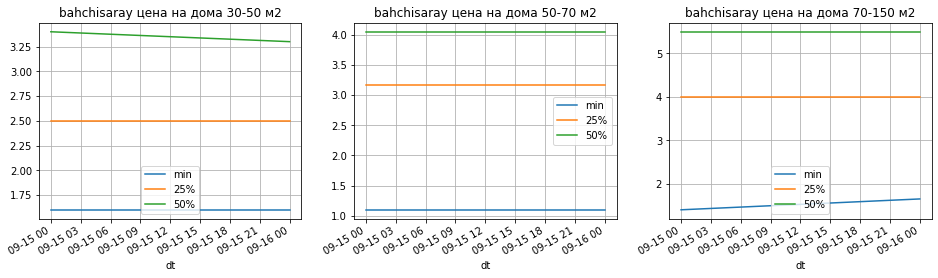

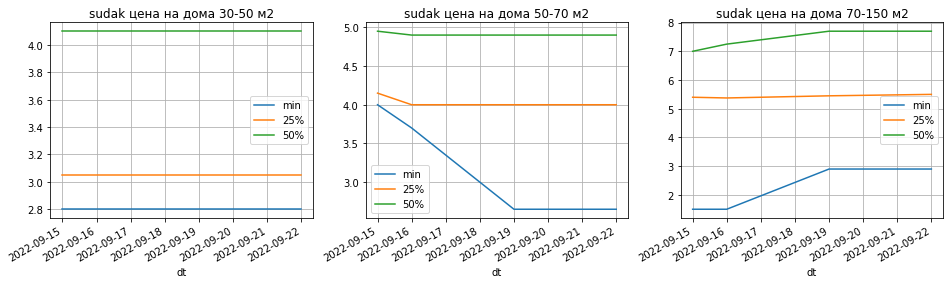

In [17]:
import matplotlib.pyplot as plt

sizes = ['30-50','50-70','70-150',]
places = gdf['place'].unique()
for p in places: 
    fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
    for i,s in enumerate(sizes): 
        stat.loc[(p,s),['min','25%','50%']].plot(grid=True, title=f'{p} цена на дома {s} м2',ax=ax[i])

In [18]:
# gdf[['latitude','longitude']].dropna().astype(float).min(axis=0) #agg({'latitude':['max','min']})

In [19]:
# latitude    44.42 47.10
# longitude   33.40 37.55

## гексагональная сетка

In [20]:
places = gdf['place'].unique()
places

array(['sevastopol', 'bahchisaray', 'sudak'], dtype=object)

In [21]:
from shapely.geometry import MultiPoint

frame_geometry = gpd.GeoDataFrame([{ 
            'place':p, 
            'geometry':MultiPoint( gdf[gdf['place']==p]['geometry'].tolist() ).convex_hull, 
        } for p in places ]
    ,crs='EPSG:4326')

In [22]:
frame_geometry.explore('place',legend=True,cmap='rainbow')

In [23]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,place,cell_size=8,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({'place':place,'hex_id': hexs, 'geometry':list(map(polygonise, hexs)), },crs=crs,)

In [24]:
places = { # размеры сетки для разных мест
'sevastopol':6,
'sudak':8,
'bahchisaray':6,
}

grid = gpd.GeoDataFrame(
    pd.concat([
        cover_grid_hexagonal(frame_geometry[ frame_geometry['place']==p ]['geometry'].values[0],p,cell_size=cs)
        for p,cs in places.items()
        ], ignore_index=True)
    ,crs='EPSG:4326'
)

grid.explore('place',cmap='rainbow')

### медиана актуальной цены

In [25]:
place = ['bahchisaray',]

grid_ =  grid[grid['place'].isin(place)]

grid_values = (
   grid_.sjoin( gdf[ (gdf['dt']>ts) & (gdf['priceM']<15.) ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid_.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [26]:
place = ['sevastopol',]

grid_ =  grid[grid['place'].isin(place)]

grid_values = (
   grid_.sjoin( gdf[ (gdf['dt']>ts) & (gdf['priceM']<15.) ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid_.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [27]:
place = ['sudak',]

grid_ =  grid[grid['place'].isin(place)]

grid_values = (
   grid_.sjoin( gdf[ (gdf['dt']>ts) & (gdf['priceM']<15.) ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid_.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

---